# Chapter 7: Deep Learning: Exercise

$$ % Latex macros
\newcommand{\mat}[1]{\begin{pmatrix} #1 \end{pmatrix}}
\newcommand{\p}[2]{\frac{\partial #1}{\partial #2}}
\renewcommand{\b}[1]{\boldsymbol{#1}}
\newcommand{\w}{\boldsymbol{w}}
\newcommand{\x}{\boldsymbol{x}}
\newcommand{\y}{\boldsymbol{y}}
\newcommand{\z}{\boldsymbol{z}}
$$

**1.** Try back-propagation learning with different function approximation or classification tasks. See how the choices of numbers of layers $L$ and units $M^l$, as well as data size $N$ and the learning rate $\alpha$ affect learning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.patches as patches
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X, y = mnist.data, mnist.target.astype(int)

# Normalize the data
X = X / 255.0

# Convert labels to one-hot encoding
def to_one_hot(y, num_classes=10):
    one_hot = np.zeros((len(y), num_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

y_onehot = to_one_hot(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Input dimension: {X_train.shape[1]}")
print(f"Output dimension: {y_train.shape[1]}")

class SimpleNeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.layers = []
        
        # Build layer sizes
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        
        for i in range(len(layer_sizes) - 1):
            # Xavier initialization
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)
    
    def sigmoid(self, x):
        # Stable sigmoid to avoid overflow
        return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
    
    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def softmax(self, x):
        # Stable softmax
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        
        current_input = X
        
        # Forward pass through hidden layers
        for i in range(len(self.weights) - 1):
            z = np.dot(current_input, self.weights[i]) + self.biases[i]
            activation = self.sigmoid(z)
            self.z_values.append(z)
            self.activations.append(activation)
            current_input = activation
        
        # Output layer with softmax
        z_output = np.dot(current_input, self.weights[-1]) + self.biases[-1]
        output = self.softmax(z_output)
        self.z_values.append(z_output)
        self.activations.append(output)
        
        return output
    
    def backward(self, X, y_true, y_pred):
        m = X.shape[0]
        
        # Initialize gradients
        weight_gradients = []
        bias_gradients = []
        
        # Output layer error
        delta = y_pred - y_true
        
        # Backpropagate through all layers
        for i in range(len(self.weights) - 1, -1, -1):
            # Compute gradients
            dW = np.dot(self.activations[i].T, delta) / m
            db = np.sum(delta, axis=0, keepdims=True) / m
            
            weight_gradients.insert(0, dW)
            bias_gradients.insert(0, db)
            
            # Compute delta for previous layer (if not input layer)
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(self.z_values[i-1])
        
        return weight_gradients, bias_gradients
    
    def update_weights(self, weight_gradients, bias_gradients):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * weight_gradients[i]
            self.biases[i] -= self.learning_rate * bias_gradients[i]
    
    def train(self, X, y, epochs=100, batch_size=32):
        losses = []
        accuracies = []
        
        for epoch in range(epochs):
            # Mini-batch training
            for i in range(0, X.shape[0], batch_size):
                batch_X = X[i:i+batch_size]
                batch_y = y[i:i+batch_size]
                
                # Forward pass
                y_pred = self.forward(batch_X)
                
                # Backward pass
                weight_gradients, bias_gradients = self.backward(batch_X, batch_y, y_pred)
                
                # Update weights
                self.update_weights(weight_gradients, bias_gradients)
            
            # Calculate loss and accuracy for entire dataset
            y_pred_full = self.forward(X)
            loss = self.cross_entropy_loss(y, y_pred_full)
            accuracy = self.accuracy(y, y_pred_full)
            
            losses.append(loss)
            accuracies.append(accuracy)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
        
        return losses, accuracies
    
    def cross_entropy_loss(self, y_true, y_pred):
        # Avoid log(0) by adding small epsilon
        epsilon = 1e-7
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
    def accuracy(self, y_true, y_pred):
        predicted_labels = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        return np.mean(predicted_labels == true_labels)
    
    def predict(self, X):
        return self.forward(X)

print("Neural Network class implemented successfully!")

Loading MNIST dataset...
Training set size: 56000
Test set size: 14000
Input dimension: 784
Output dimension: 10
Neural Network class implemented successfully!
Training set size: 56000
Test set size: 14000
Input dimension: 784
Output dimension: 10
Neural Network class implemented successfully!


In [ ]:
# Interactive Neural Network with Real-time Updating Sliders
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# Set matplotlib to inline for compatibility
%matplotlib inline

class InteractiveNeuralNetwork:
    def __init__(self):
        self.current_model = None
        self.training_history = None
        self.output_widget = widgets.Output()
        self.setup_widgets()
        self.update_plots()  # Initial plot
        
    def setup_widgets(self):
        """Create interactive widgets"""
        # Create sliders with observe functionality
        self.layers_slider = widgets.IntSlider(
            value=2, min=1, max=5, step=1,
            description='Layers:', style={'description_width': '120px'},
            layout=widgets.Layout(width='300px')
        )
        
        self.units_slider = widgets.IntSlider(
            value=50, min=10, max=200, step=10,
            description='Units/Layer:', style={'description_width': '120px'},
            layout=widgets.Layout(width='300px')
        )
        
        self.data_size_slider = widgets.IntSlider(
            value=1000, min=100, max=10000, step=100,
            description='Data Size:', style={'description_width': '120px'},
            layout=widgets.Layout(width='300px')
        )
        
        self.lr_slider = widgets.FloatSlider(
            value=0.01, min=0.001, max=0.1, step=0.001,
            description='Learning Rate:', style={'description_width': '120px'},
            readout_format='.3f', layout=widgets.Layout(width='300px')
        )
        
        self.epochs_slider = widgets.IntSlider(
            value=50, min=10, max=100, step=5,
            description='Epochs:', style={'description_width': '120px'},
            layout=widgets.Layout(width='300px')
        )
        
        # Create train button
        self.train_button = widgets.Button(
            description='🚀 Train Model',
            button_style='success',
            tooltip='Click to train with current parameters',
            layout=widgets.Layout(width='200px', height='40px')
        )
        
        # Create info display
        self.info_text = widgets.HTML(
            value="<b>Ready to configure network...</b>",
            layout=widgets.Layout(width='100%', height='100px')
        )
        
        # Connect sliders to update functions
        for slider in [self.layers_slider, self.units_slider, self.data_size_slider, 
                      self.lr_slider, self.epochs_slider]:
            slider.observe(self.on_parameter_change, names='value')
            
        self.train_button.on_click(self.train_model)
        
        # Initial parameter update
        self.on_parameter_change({'new': None})
        
    def on_parameter_change(self, change):
        """Called when any parameter changes"""
        self.update_info_display()
        self.update_plots()
        
    def update_info_display(self):
        """Update parameter information display"""
        # Get current parameters
        num_layers = self.layers_slider.value
        units_per_layer = self.units_slider.value
        data_size = self.data_size_slider.value
        learning_rate = self.lr_slider.value
        epochs = self.epochs_slider.value
        
        # Calculate total parameters
        layer_sizes = [784] + [units_per_layer] * num_layers + [10]
        total_params = 0
        for i in range(len(layer_sizes) - 1):
            total_params += layer_sizes[i] * layer_sizes[i+1] + layer_sizes[i+1]  # weights + biases
        
        # Estimate training time (rough)
        est_time = (data_size * epochs) / 8000  # Very rough estimate
        
        # Create HTML info
        info_html = f"""
        <div style='background-color: #f0f0f0; padding: 10px; border-radius: 5px; font-family: monospace;'>
        <h4>🧠 Current Network Configuration</h4>
        <b>Architecture:</b> {num_layers} hidden layers, {units_per_layer} units each<br>
        <b>Total Parameters:</b> {total_params:,}<br>
        <b>Training Data:</b> {data_size:,} samples<br>
        <b>Learning Rate:</b> {learning_rate:.3f}<br>
        <b>Training Epochs:</b> {epochs}<br>
        <b>Est. Training Time:</b> ~{est_time:.1f} seconds<br>
        <hr>
        <i>💡 Adjust sliders above to see real-time changes in network architecture!</i>
        </div>
        """
        
        self.info_text.value = info_html
        
    def update_plots(self):
        """Update all plots"""
        with self.output_widget:
            clear_output(wait=True)
            
            # Create figure with better spacing
            fig = plt.figure(figsize=(16, 12))
            
            # Create custom gridspec for better layout control
            gs = fig.add_gridspec(3, 4, height_ratios=[1, 1, 0.8], width_ratios=[1, 1, 1, 1],
                                 hspace=0.4, wspace=0.3, left=0.08, right=0.95, 
                                 top=0.92, bottom=0.08)
            
            # Top row: Network architecture and parameter effects
            ax1 = fig.add_subplot(gs[0, :2])  # Network architecture (spans 2 columns)
            ax2 = fig.add_subplot(gs[0, 2:])  # Parameter effects (spans 2 columns)
            
            # Middle row: Training curves
            ax3 = fig.add_subplot(gs[1, :2])  # Training loss (spans 2 columns)
            ax4 = fig.add_subplot(gs[1, 2:])  # Training accuracy (spans 2 columns)
            
            # Bottom row: Sample predictions
            ax5 = fig.add_subplot(gs[2, :])   # Sample predictions (spans full width)
            
            # Network architecture visualization
            self.plot_network_architecture(ax1)
            
            # Parameter visualization
            self.plot_parameter_effects(ax2)
            
            # Training curves (empty initially)
            if self.training_history:
                self.plot_training_curves(ax3, ax4)
                self.plot_sample_predictions(ax5)
            else:
                ax3.text(0.5, 0.5, 'Training Loss Results\nWill Appear Here', 
                        ha='center', va='center', transform=ax3.transAxes, 
                        fontsize=14, style='italic', color='gray')
                ax3.set_title('📉 Training Loss', fontsize=12, fontweight='bold')
                ax3.grid(True, alpha=0.3)
                
                ax4.text(0.5, 0.5, 'Training Accuracy Results\nWill Appear Here', 
                        ha='center', va='center', transform=ax4.transAxes, 
                        fontsize=14, style='italic', color='gray')
                ax4.set_title('📈 Training Accuracy', fontsize=12, fontweight='bold')
                ax4.grid(True, alpha=0.3)
                
                ax5.text(0.5, 0.5, 'Sample Predictions Will Appear Here After Training', 
                        ha='center', va='center', transform=ax5.transAxes, 
                        fontsize=14, style='italic', color='gray')
                ax5.set_title('🎯 Sample Predictions', fontsize=12, fontweight='bold')
                ax5.axis('off')
            
            plt.suptitle('🧠 Interactive Neural Network - Real-time Parameter Visualization', 
                        fontsize=18, fontweight='bold', y=0.96)
            
            # Force the layout and display
            plt.show(block=False)
            plt.draw()
            
    def plot_network_architecture(self, ax):
        """Plot the network architecture"""
        ax.clear()
        
        num_layers = self.layers_slider.value
        units_per_layer = self.units_slider.value
        
        # Define layer sizes
        layer_sizes = [784] + [units_per_layer] * num_layers + [10]
        
        # Visualization parameters
        layer_positions = np.linspace(0.1, 0.9, len(layer_sizes))
        max_nodes_to_show = min(6, units_per_layer)
        
        # Draw layers
        for i, (pos, size) in enumerate(zip(layer_positions, layer_sizes)):
            if i == 0:  # Input layer
                nodes_to_show = min(size, 8)
                color = 'lightblue'
                label = f'Input\\n{size}'
            elif i == len(layer_sizes) - 1:  # Output layer
                nodes_to_show = size
                color = 'lightgreen'
                label = f'Output\\n{size}'
            else:  # Hidden layers
                nodes_to_show = max_nodes_to_show
                color = 'lightcoral'
                label = f'H{i}\\n{size}'
            
            # Calculate node positions
            if nodes_to_show == 1:
                node_positions = [0.5]
            else:
                node_positions = np.linspace(0.15, 0.85, nodes_to_show)
            
            # Draw nodes
            for j, node_pos in enumerate(node_positions):
                circle = patches.Circle((pos, node_pos), 0.03, 
                                      facecolor=color, edgecolor='black', linewidth=1)
                ax.add_patch(circle)
            
            # Add dots if not showing all nodes
            if size > nodes_to_show:
                ax.text(pos, 0.05, '⋮', ha='center', va='center', fontsize=16, fontweight='bold')
            
            # Add layer labels
            ax.text(pos, -0.05, label, ha='center', va='top', fontsize=9, fontweight='bold')
            
            # Draw connections
            if i < len(layer_sizes) - 1:
                next_pos = layer_positions[i + 1]
                if i + 1 == len(layer_sizes) - 1:  # To output layer
                    next_nodes = layer_sizes[i + 1]
                    next_node_positions = np.linspace(0.15, 0.85, next_nodes) if next_nodes > 1 else [0.5]
                else:
                    next_node_positions = np.linspace(0.15, 0.85, max_nodes_to_show)
                
                # Draw sample connections
                for j in range(0, len(node_positions), max(1, len(node_positions)//2)):
                    for k in range(0, len(next_node_positions), max(1, len(next_node_positions)//2)):
                        ax.plot([pos, next_pos], [node_positions[j], next_node_positions[k]], 
                               'k-', alpha=0.2, linewidth=0.5)
        
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.1, 1.0)
        ax.set_aspect('equal')
        ax.set_title(f'🏗️ Network Architecture\\n{num_layers} Hidden × {units_per_layer} Units')
        ax.axis('off')
        
    def plot_parameter_effects(self, ax):
        """Plot parameter effects visualization"""
        ax.clear()
        
        # Create a simple visualization showing parameter relationships
        params = ['Layers', 'Units', 'Data Size', 'Learn Rate', 'Epochs']
        values = [
            self.layers_slider.value / 5,
            self.units_slider.value / 200,
            self.data_size_slider.value / 10000,
            self.lr_slider.value / 0.1,
            self.epochs_slider.value / 100
        ]
        
        colors = ['red', 'orange', 'yellow', 'green', 'blue']
        bars = ax.barh(params, values, color=colors, alpha=0.7)
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, values)):
            ax.text(val + 0.01, i, f'{val:.2f}', va='center', fontweight='bold')
        
        ax.set_xlim(0, 1.2)
        ax.set_title('📊 Parameter Settings\\n(Normalized 0-1)')
        ax.set_xlabel('Relative Value')
        
    def plot_training_curves(self, ax_loss, ax_acc):
        """Plot training loss and accuracy curves"""
        if not self.training_history:
            return
            
        epochs = range(len(self.training_history['losses']))
        
        # Loss plot
        ax_loss.clear()
        ax_loss.plot(epochs, self.training_history['losses'], 'b-', linewidth=3, 
                    marker='o', markersize=5, alpha=0.8)
        ax_loss.set_title('📉 Training Loss', fontsize=12, fontweight='bold')
        ax_loss.set_xlabel('Epoch', fontsize=10)
        ax_loss.set_ylabel('Cross-Entropy Loss', fontsize=10)
        ax_loss.grid(True, alpha=0.3)
        
        # Add final loss value
        final_loss = self.training_history['losses'][-1]
        ax_loss.text(0.02, 0.98, f'Final: {final_loss:.4f}', 
                    transform=ax_loss.transAxes, fontsize=10, va='top',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        
        # Accuracy plot
        ax_acc.clear()
        ax_acc.plot(epochs, self.training_history['accuracies'], 'r-', linewidth=3, 
                   marker='s', markersize=5, alpha=0.8)
        ax_acc.set_title('📈 Training Accuracy', fontsize=12, fontweight='bold')
        ax_acc.set_xlabel('Epoch', fontsize=10)
        ax_acc.set_ylabel('Accuracy', fontsize=10)
        ax_acc.set_ylim(0, 1)
        ax_acc.grid(True, alpha=0.3)
        
        # Add final accuracy value
        final_acc = self.training_history['accuracies'][-1]
        ax_acc.text(0.02, 0.02, f'Final: {final_acc:.4f}', 
                   transform=ax_acc.transAxes, fontsize=10, va='bottom',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
        
    def plot_sample_predictions(self, ax):
        """Plot sample predictions"""
        if not self.current_model:
            return
            
        ax.clear()
        
        # Get test samples
        n_samples = 8
        indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
        sample_X = X_test[indices]
        sample_y = y_test[indices]
        
        # Make predictions
        predictions = self.current_model.predict(sample_X)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(sample_y, axis=1)
        
        # Create subplots within the main axes
        for i in range(n_samples):
            # Calculate position for each subplot
            row = i // 4
            col = i % 4
            
            # Create position [left, bottom, width, height] in axes coordinates
            subplot_width = 0.22
            subplot_height = 0.4
            left = 0.05 + col * 0.24
            bottom = 0.55 - row * 0.5
            
            # Create inset axes
            ax_sub = ax.inset_axes([left, bottom, subplot_width, subplot_height])
            
            # Display image
            img = sample_X[i].reshape(28, 28)
            ax_sub.imshow(img, cmap='gray')
            
            # Set title with prediction
            is_correct = predicted_labels[i] == true_labels[i]
            color = 'green' if is_correct else 'red'
            confidence = predictions[i][predicted_labels[i]]
            
            ax_sub.set_title(f'True: {true_labels[i]}, Pred: {predicted_labels[i]}\nConf: {confidence:.2f}', 
                           color=color, fontsize=9, fontweight='bold')
            ax_sub.axis('off')
        
        # Calculate accuracy
        accuracy = np.mean(predicted_labels == true_labels)
        
        # Set main title and info
        ax.set_title('🎯 Sample Predictions', fontsize=12, fontweight='bold')
        ax.text(0.5, 0.05, f'Sample Accuracy: {accuracy:.2f} (Green=Correct, Red=Incorrect)', 
               transform=ax.transAxes, ha='center', fontsize=11, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        
    def train_model(self, button=None):
        """Train the neural network"""
        # Update button state
        self.train_button.description = '⏳ Training...'
        self.train_button.disabled = True
        
        try:
            # Get parameters
            num_layers = self.layers_slider.value
            units_per_layer = self.units_slider.value
            data_size = self.data_size_slider.value
            learning_rate = self.lr_slider.value
            epochs = self.epochs_slider.value
            
            # Prepare data
            indices = np.random.choice(X_train.shape[0], min(data_size, X_train.shape[0]), replace=False)
            X_subset = X_train[indices]
            y_subset = y_train[indices]
            
            # Create model
            hidden_sizes = [units_per_layer] * num_layers
            self.current_model = SimpleNeuralNetwork(
                input_size=784,
                hidden_sizes=hidden_sizes,
                output_size=10,
                learning_rate=learning_rate
            )
            
            print(f"🚀 Training started: {num_layers} layers × {units_per_layer} units, {data_size} samples...")
            
            # Train
            losses, accuracies = self.current_model.train(X_subset, y_subset, epochs=epochs, batch_size=32)
            self.training_history = {'losses': losses, 'accuracies': accuracies}
            
            # Update plots
            self.update_plots()
            
            final_acc = accuracies[-1]
            print(f"✅ Training completed! Final accuracy: {final_acc:.3f}")
            
        except Exception as e:
            print(f"❌ Training failed: {e}")
        finally:
            # Reset button
            self.train_button.description = '🚀 Train Model'
            self.train_button.disabled = False
    
    def display(self):
        """Display the complete interface"""
        # Create layout
        controls_left = widgets.VBox([
            widgets.HTML("<h3>🎛️ Network Architecture</h3>"),
            self.layers_slider,
            self.units_slider,
        ])
        
        controls_right = widgets.VBox([
            widgets.HTML("<h3>⚙️ Training Parameters</h3>"),
            self.data_size_slider,
            self.lr_slider,
            self.epochs_slider,
        ])
        
        controls = widgets.HBox([controls_left, controls_right])
        
        train_section = widgets.VBox([
            widgets.HTML("<h3>🚀 Training Control</h3>"),
            self.train_button,
            self.info_text
        ])
        
        # Main interface
        interface = widgets.VBox([
            widgets.HTML("<h2>🧠 Interactive Neural Network Training on MNIST</h2>"),
            widgets.HTML("<p><i>Adjust the sliders below to see real-time changes in the network architecture!</i></p>"),
            controls,
            train_section,
            widgets.HTML("<hr>"),
            widgets.HTML("<h3>📊 Real-time Visualization</h3>"),
            self.output_widget
        ])
        
        display(interface)

# Create and display the interactive neural network
print("🚀 Creating fully interactive neural network with real-time sliders...")
print("📊 The sliders will update the visualization immediately as you move them!")
print("🎯 Use the 'Train Model' button to start training with your parameters.")

interactive_nn = InteractiveNeuralNetwork()
interactive_nn.display()

🚀 Creating fully interactive neural network with real-time sliders...
📊 The sliders will update the visualization immediately as you move them!
🎯 Use the 'Train Model' button to start training with your parameters.


In [3]:
# Additional usage instructions and tips
print("\n" + "="*80)
print("✨ INTERACTIVE NEURAL NETWORK - USAGE GUIDE")
print("="*80)
print("🎛️  SLIDERS: Move sliders to see real-time architecture changes")
print("📊  VISUALIZATION: Watch parameter effects and network structure update instantly")
print("🚀  TRAINING: Click 'Train Model' to train with your current settings")
print("📈  RESULTS: Training curves and sample predictions appear after training")
print("🔄  EXPERIMENT: Try different combinations to see their effects!")
print("\n💡 TIPS:")
print("   • Start with fewer layers (1-2) and moderate units (50-100)")
print("   • Use smaller datasets (1000-2000) for faster experimentation")
print("   • Learning rates around 0.01-0.05 work well for most cases")
print("   • Higher layer counts increase model capacity but training time")
print("="*80)

# Display some example configurations
examples = [
    {"name": "🚀 Quick Test", "layers": 1, "units": 32, "data": 500, "lr": 0.02, "epochs": 20},
    {"name": "🎯 Balanced", "layers": 2, "units": 64, "data": 2000, "lr": 0.01, "epochs": 40},
    {"name": "🔥 Deep Network", "layers": 4, "units": 128, "data": 5000, "lr": 0.005, "epochs": 60},
    {"name": "⚡ Speed Run", "layers": 1, "units": 20, "data": 200, "lr": 0.05, "epochs": 15}
]

print("\n🎯 SUGGESTED CONFIGURATIONS TO TRY:")
for ex in examples:
    print(f"   {ex['name']}: {ex['layers']} layers, {ex['units']} units, {ex['data']} samples, LR={ex['lr']}, {ex['epochs']} epochs")

print("\n🎉 Ready to explore! Use the interactive widget above to experiment!")
print("="*80)


✨ INTERACTIVE NEURAL NETWORK - USAGE GUIDE
🎛️  SLIDERS: Move sliders to see real-time architecture changes
📊  VISUALIZATION: Watch parameter effects and network structure update instantly
🚀  TRAINING: Click 'Train Model' to train with your current settings
📈  RESULTS: Training curves and sample predictions appear after training
🔄  EXPERIMENT: Try different combinations to see their effects!

💡 TIPS:
   • Start with fewer layers (1-2) and moderate units (50-100)
   • Use smaller datasets (1000-2000) for faster experimentation
   • Learning rates around 0.01-0.05 work well for most cases
   • Higher layer counts increase model capacity but training time

🎯 SUGGESTED CONFIGURATIONS TO TRY:
   🚀 Quick Test: 1 layers, 32 units, 500 samples, LR=0.02, 20 epochs
   🎯 Balanced: 2 layers, 64 units, 2000 samples, LR=0.01, 40 epochs
   🔥 Deep Network: 4 layers, 128 units, 5000 samples, LR=0.005, 60 epochs
   ⚡ Speed Run: 1 layers, 20 units, 200 samples, LR=0.05, 15 epochs

🎉 Ready to explore! Use

Running a quick demonstration with preset parameters...
Training on 1000 samples for 30 epochs...
Epoch 0: Loss = 2.3197, Accuracy = 0.1370
Epoch 0: Loss = 2.3197, Accuracy = 0.1370
Epoch 10: Loss = 2.2352, Accuracy = 0.2540
Epoch 10: Loss = 2.2352, Accuracy = 0.2540
Epoch 20: Loss = 2.1716, Accuracy = 0.3450
Epoch 20: Loss = 2.1716, Accuracy = 0.3450


<Figure size 640x480 with 0 Axes>

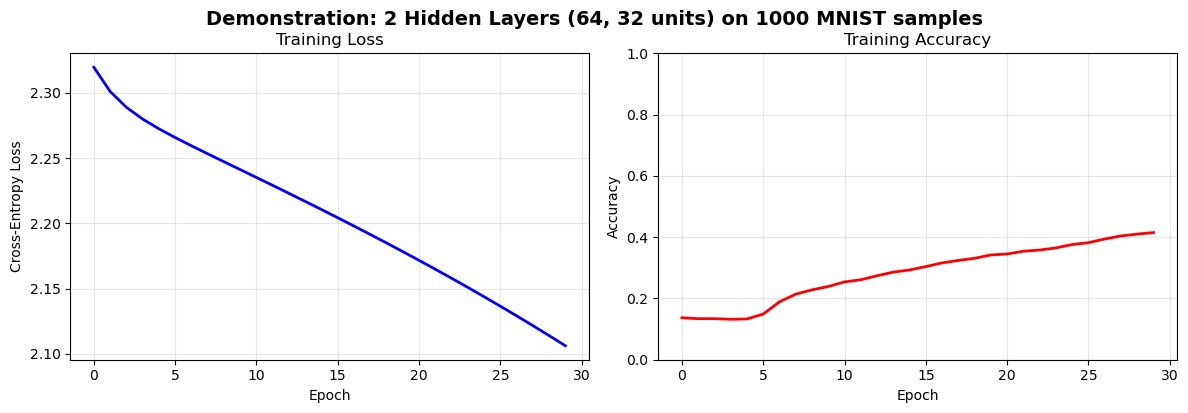

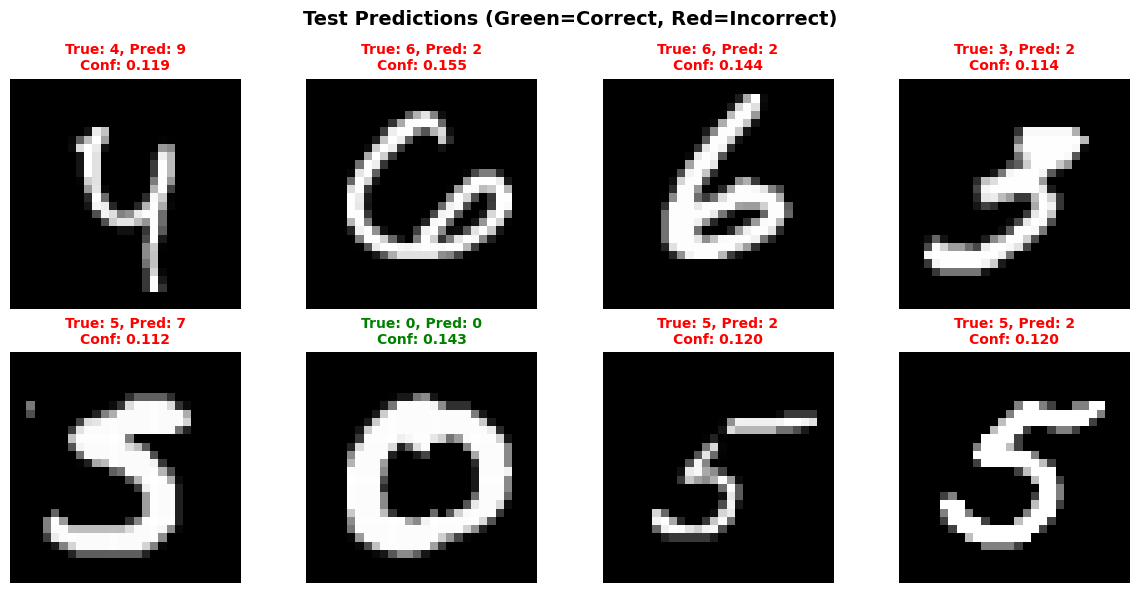


Final training accuracy: 0.4150
Test accuracy on 8 samples: 0.1250

INSTRUCTIONS FOR INTERACTIVE VISUALIZATION:
1. Use the sliders to adjust:
   - Layers: Number of hidden layers (1-5)
   - Units/Layer: Number of units in each hidden layer (10-200)
   - Data Size: Number of training samples to use (100-10000)
   - Learning Rate: Step size for gradient descent (0.001-0.1)
   - Epochs: Number of training iterations (10-100)
2. Click 'Train Model' to start training with current parameters
3. Watch the training progress in the loss and accuracy plots
4. View sample predictions at the bottom
5. Experiment with different combinations to see their effects!


In [4]:
# Simple demonstration with preset parameters
print("Running a quick demonstration with preset parameters...")

# Create a simple network for demonstration
demo_model = SimpleNeuralNetwork(
    input_size=784,
    hidden_sizes=[64, 32],  # 2 hidden layers with 64 and 32 units
    output_size=10,
    learning_rate=0.01
)

# Use a small subset for quick demonstration
demo_size = 1000
demo_indices = np.random.choice(X_train.shape[0], demo_size, replace=False)
X_demo = X_train[demo_indices]
y_demo = y_train[demo_indices]

print(f"Training on {demo_size} samples for 30 epochs...")

# Train the model
demo_losses, demo_accuracies = demo_model.train(X_demo, y_demo, epochs=30, batch_size=32)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
ax1.plot(demo_losses, 'b-', linewidth=2)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(demo_accuracies, 'r-', linewidth=2)
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.suptitle('Demonstration: 2 Hidden Layers (64, 32 units) on 1000 MNIST samples', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Test on a few samples
test_indices = np.random.choice(X_test.shape[0], 8, replace=False)
test_samples = X_test[test_indices]
test_labels = y_test[test_indices]

predictions = demo_model.predict(test_samples)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Display test samples with predictions
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    img = test_samples[i].reshape(28, 28)
    axes[i].imshow(img, cmap='gray')
    
    # Color code: green for correct, red for incorrect
    color = 'green' if predicted_labels[i] == true_labels[i] else 'red'
    confidence = predictions[i][predicted_labels[i]]
    
    axes[i].set_title(f'True: {true_labels[i]}, Pred: {predicted_labels[i]}\nConf: {confidence:.3f}', 
                     color=color, fontsize=10, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Test Predictions (Green=Correct, Red=Incorrect)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nFinal training accuracy: {demo_accuracies[-1]:.4f}")
print(f"Test accuracy on 8 samples: {np.mean(predicted_labels == true_labels):.4f}")

print("\n" + "="*60)
print("INSTRUCTIONS FOR INTERACTIVE VISUALIZATION:")
print("="*60)
print("1. Use the sliders to adjust:")
print("   - Layers: Number of hidden layers (1-5)")
print("   - Units/Layer: Number of units in each hidden layer (10-200)")
print("   - Data Size: Number of training samples to use (100-10000)")
print("   - Learning Rate: Step size for gradient descent (0.001-0.1)")
print("   - Epochs: Number of training iterations (10-100)")
print("2. Click 'Train Model' to start training with current parameters")
print("3. Watch the training progress in the loss and accuracy plots")
print("4. View sample predictions at the bottom")
print("5. Experiment with different combinations to see their effects!")
print("="*60)

**2.** Implement deep neural networks with ReLU activation functions for the hidden units or softmax for the output units.

**3.** Run the restricted Boltzmann machine with diffent input patterns, the number of hidden units $M_h$, and the cycle of contrastive divergence $K$.